## Interaction network template
Produces an interaction list from a ```.mymridon``` experiment file and saves it as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio.  
This notebook is a walk trough a sample usage of the following:
* the py-myrmidon library ([Documentation](https://formicidae-tracker.github.io/myrmidon/latest/))
* the facetnet library ([Documentation](https://c4science.ch/source/facet_unil/))


In [15]:
import py_fort_myrmidon as fm
import numpy as np  # Fundamental math library in python. Here used only for convience: to save the csv.
from datetime import datetime  # For convenient handling of time and date
import networkx as nx  # Optional: for general graph analysis and plotting
import facetnet  # Optional: for community analysis
import matplotlib.pyplot as plt  # Optional: for plorring
# Optional: makes plots interactive:
%matplotlib widget

In [16]:
f_myrmidon = "/home/user/Documents/experiment_folder/exp.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)

A matcher is used to filter interactions of a certain type ("body part 1 with body part 1") that were recorded during a user define period from ```t_start``` to ```t_end```. The ```for``` loop takes the ```ant_id``` of both individuals invovled in the interaction, converts the float number to an integer for readability (the part inside the ```append()```) and stores the pair in the ```interaction_graph_edgelist``` list. The list is then saved to csv with name that consists of the experiment name and the dates. This is to avoid confusion, any string can serve as a file name.

In [24]:
m = fm.Matcher.InteractionType(1, 1)
t_start = fm.Time(datetime(2021, 2, 18, 0, 1))  # <year, month, day, hour, minute>
t_end = fm.Time(datetime(2021, 2, 18, 1, 0))

interactions = fm.Query.ComputeAntInteractions(exp, start=t_start, end=t_end, matcher=m)
interaction_graph_edgelist = []
for interaction in interactions[1]:
    interaction_graph_edgelist.append([int(idx) for idx in interaction.IDs])
f_edgelist = "edgelist_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
np.savetxt(f_edgelist, interaction_graph_edgelist)

### Optional part 1: graph visualization using networkx library
For convenience, the facetnet library is used and the previously written csv is parsed again. There are other, more elegant ways to do this. The grap is plotted using the spring model, a common way to visualize graphs.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
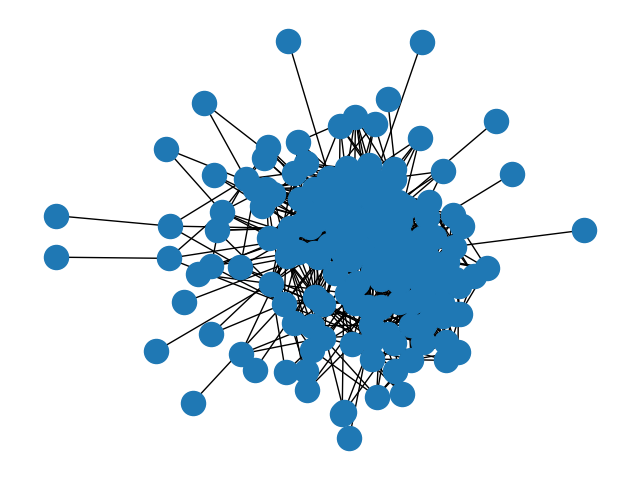

In [30]:
graph = nx.read_edgelist(f_edgelist)
nx.draw_spring(graph)

### Optional part 2: community detection using facetnet
A fixed number of community is assumed. Facetnet returns a resulting soft modularity score of the community detection, as well as the soft community membership for each individual and each community, which can be understood as membership "percentage". The graph is then plotted again with a node color representing community membership. Facetnet can also be used as a command line tool to process the saved csv directly.

soft modularity score:  0.2087653505640864


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
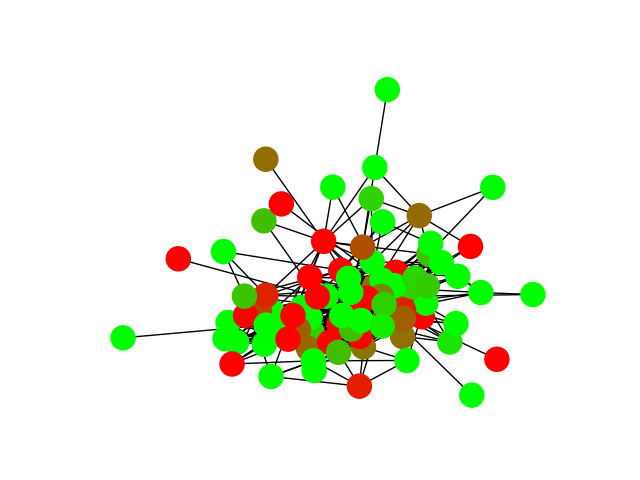

In [50]:
nb_communities = 2
iact_ids = np.asarray(interaction_graph_edgelist)
idmap, idmap_inv, wc = facetnet.read_edge_list(iact_ids)
_, _, _, _, qc_s_res, soft_comm, _, _, _, _ = facetnet.step(idmap, idmap_inv, wc, 0.7, nb_communities)
fig, ax = plt.subplots()
color_nodes = []
for i in range(len(soft_comm)):
    # red, green, blue value. Red means community 0, green means community 1
    color_nodes.append((soft_comm[i, 0], soft_comm[i, 1], 0))
nx.draw_spring(graph, node_color=np.asarray(color_nodes))
print("soft modularity score: ", qc_s_res)